# **Moving to ResNets**

In [1]:
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

## **Setup**

In [3]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024
x_mean, x_std = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - x_mean) / x_std for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [4]:
for batch in dls.train: 
    print(f"Batch Size: {batch[0].shape}")
    break

Batch Size: torch.Size([1024, 1, 28, 28])


In [5]:
# Activations with our trusty General RelU
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [7]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num Params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res, tot
        nparams = sum(o.numel() for o in mod.parameters())
        tot += nparams
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Total params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

## **Moving Toward Deeper Architectures**

Prior to moving onto ResNets, we can experiment with increasing the depth of our ConvNet model. This should be possible since we were initializing our weights pretty effectively while using BatchNorm.

Previously, we had a model which peaked at 64 output channels / filters. To increase output filters to 128, we can:
1. Set the inputs and outputs to `conv(1, 8)` with a stride of 1.
2. This would allow the network to be deeper and wider as a result.

In [8]:
# for comparison
??get_model

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      ~/nbs/course22p2/miniai/init.py
Type:      function

In [9]:
# Updating the get_model() function for additional filters.
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128), norm=nn.BatchNorm2d):
    # initialize the first layer separately to have a wider and deeper network
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [10]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Total params:  110286


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


|Module|Input|Output|Num Params|
|--|--|--|--|
|Sequential|(2048, 1, 28, 28)|(2048, 8, 28, 28)|96|
|Sequential|(2048, 8, 28, 28)|(2048, 16, 14, 14)|1200|
|Sequential|(2048, 16, 14, 14)|(2048, 32, 7, 7)|4704|
|Sequential|(2048, 32, 7, 7)|(2048, 64, 4, 4)|18624|
|Sequential|(2048, 64, 4, 4)|(2048, 128, 2, 2)|74112|
|Sequential|(2048, 128, 2, 2)|(2048, 10, 1, 1)|11550|
|Flatten|(2048, 10, 1, 1)|(2048, 10)|0|


`NOTE` This summary table shows that there may be an issue with fastcore versioning here. Everything else seems to pan out.

In [11]:
set_seed(42)

lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
 # Adding the scheduler
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.809,0.692,0,train
0.829,0.543,0,eval
0.885,0.332,1,train
0.862,0.392,1,eval
0.908,0.261,2,train
0.895,0.290,2,eval
0.926,0.209,3,train
0.913,0.248,3,eval
0.942,0.166,4,train
0.916,0.232,4,eval


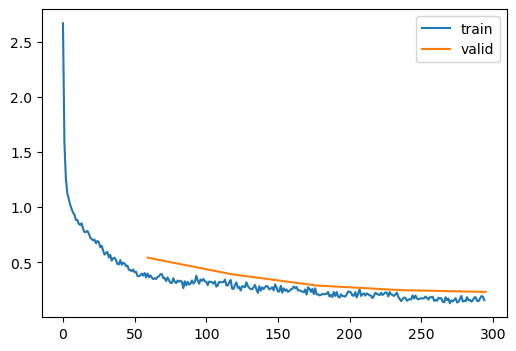

In [12]:
learn.fit(epochs)

We've hit **`91.6%`** with the simple addition of one line of code in `get_model()` which allows us to go from 8 to 128 filters. But we've also reached an inflection point i.e. adding additional width and depth will start becoming an exercise with diminishing returns.

## **Skip Connections - The Core of ResNets**

ResNets (Residual Networks) were introduced by Kaiming He et al. in 2015, in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). 

![title](imgs/kaiming.png)

The abstract states:

> Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers.

Experiments showed that training deeper (56 layers vs. 20 layers) networks, began resulting in higher errors. The main insight was that _skip / shortcut / residual connections_ allowed deeper networks to train successfully - while retaining the training dynamics of much shallower networks. 

In [13]:
# Inner convolutional block
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    # Change to stride 1
    # NOTE that this block is different compared to the lecture.
    # the init method, which initialized the batchnorm weights to 0. lead to worsening performance.
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

# NOTE that this block is different from the lecture
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm) # Convolutions
        # nothing for condition, otherwise convolution with ni, nf and stride=1
        # This changes the number of filters so that the shapes match.
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None) 
        # Condition in case there is a stride of 2, then pool the mean.
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # test
        self.act = act()
    # The activation is applied to the result of the ResNet block.
    # This is one approach to handling the block.
    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [14]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    # Previous convs in get_model() went from 128 channels to 10 channels, followed by flatten.
    # However, the convs worked with a 1x1 input. Here, we flatten first and then use a linear layer.
    # Conv on 1x1 input is equal to a linear layer.
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

Jeremy also mentioned that an important insight to convolutions is that a `conv()` on a 1x1 input is equal to a Linear layer. Based on my understanding, a convolution on a 1x1 input would reduce the kernel to the same size, effectively converting the matmul operation to much reduced form.

The detailed explanation by ChatGPT is as follows:

> A convolution on a 1×1 input tensor is equivalent to a linear (fully connected) layer because of the way the convolution operation works in this specific case:

> Kernel Size Matches Input Size: When performing a convolution with a 1×1 input, the convolutional kernel also has dimensions 1×1. This means the kernel is applied to a single pixel at a time, and no spatial information is captured since there are no neighboring pixels.

> Element-wise Multiplication and Sum: The convolution operation involves element-wise multiplication between the input and the kernel, followed by a summation of these products. Since both the input and kernel are 1×1, this operation reduces to simply multiplying the single input value by the kernel weight and potentially adding a bias term.

> No Spatial Influence: In larger inputs, convolutional layers leverage spatial relationships by sliding the kernel over the input and combining information from neighboring pixels. However, with a 1×1 input, there are no neighboring pixels, so no spatial relationships are considered. This makes the operation functionally identical to a linear transformation, where the input is multiplied by a weight and added to a bias.

> Equivalence to Linear Layer: The process described above is exactly what a linear (fully connected) layer does—each input is multiplied by a weight and summed with a bias. Therefore, a convolution on a 1×1 input is mathematically the same as applying a linear layer to that input.

>In summary, a convolution on a 1×1 input is equivalent to a linear layer because it reduces to a simple weighted sum of the input, just like a linear transformation.

In [15]:
# This function allows us to print out the shapes of our model architecture.
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)

In [16]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
# Using the Hooks context manager.
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


`NOTE` There might be an issue with the `Dataloader/ResBlock/fc.patch` or the custom hooks class since the batch number is 2x the original.

`@fc.patch` has moved to the top of the NB!

In [17]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Total params:  1228908


|Module|Input|Output|Num Params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


`NOTE` - the calculation is correct at the model level, the issue lies with the interaction between Hooks and dataloaders.

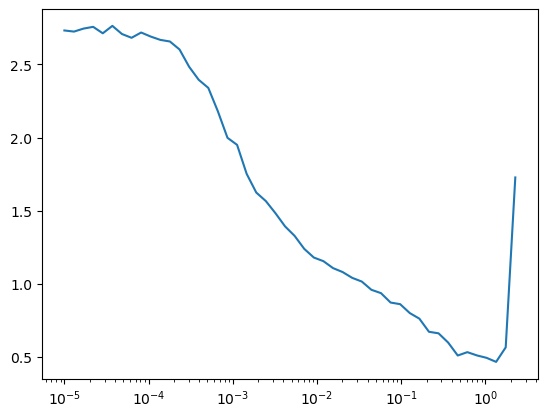

In [20]:
# Using lr_find() for the new ResNet model
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [23]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.812,0.721,0,train
0.866,0.430,0,eval
0.892,0.352,1,train
0.877,0.356,1,eval
0.916,0.250,2,train
0.905,0.277,2,eval
0.935,0.192,3,train
0.918,0.239,3,eval
0.956,0.141,4,train
0.928,0.209,4,eval


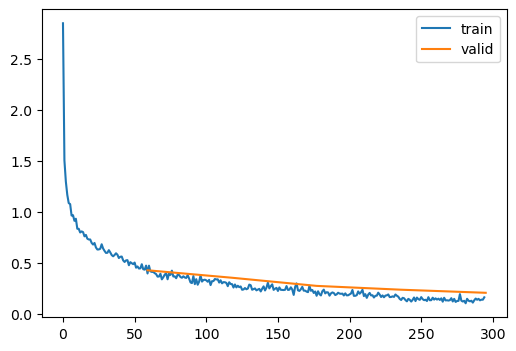

In [25]:
learn.fit(epochs)

The ResNet model has taken our accuracy to `92.8%`in just 5 epochs!!

Ross Wightman's `timm` library contains a host of ResNet models which we can experiment with. The source code of the library defines the model architectures in a very convenient and easy to read manner.

```
resnet18:  block=BasicBlock, layers=[2, 2, 2, 2]
resnet18d: block=BasicBlock, layers=[2, 2, 2, 2], stem_width=32, stem_type='deep', avg_down=True
resnet10t: block=BasicBlock, layers=[1, 1, 1, 1], stem_width=32, stem_type='deep_tiered', avg_down=True
```

In [26]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [27]:
' -- '.join(timm.list_models('*resnet*'))

'cspresnet50 -- cspresnet50d -- cspresnet50w -- eca_resnet33ts -- ecaresnet26t -- ecaresnet50d -- ecaresnet50d_pruned -- ecaresnet50t -- ecaresnet101d -- ecaresnet101d_pruned -- ecaresnet200d -- ecaresnet269d -- ecaresnetlight -- gcresnet33ts -- gcresnet50t -- inception_resnet_v2 -- lambda_resnet26rpt_256 -- lambda_resnet26t -- lambda_resnet50ts -- legacy_seresnet18 -- legacy_seresnet34 -- legacy_seresnet50 -- legacy_seresnet101 -- legacy_seresnet152 -- nf_ecaresnet26 -- nf_ecaresnet50 -- nf_ecaresnet101 -- nf_resnet26 -- nf_resnet50 -- nf_resnet101 -- nf_seresnet26 -- nf_seresnet50 -- nf_seresnet101 -- resnet10t -- resnet14t -- resnet18 -- resnet18d -- resnet26 -- resnet26d -- resnet26t -- resnet32ts -- resnet33ts -- resnet34 -- resnet34d -- resnet50 -- resnet50_clip -- resnet50_clip_gap -- resnet50_gn -- resnet50_mlp -- resnet50c -- resnet50d -- resnet50s -- resnet50t -- resnet50x4_clip -- resnet50x4_clip_gap -- resnet50x16_clip -- resnet50x16_clip_gap -- resnet50x64_clip -- resnet50

In [28]:
# Jeremy experimented with a number of resnets in timm and found this setup had comparable results to our
# hand built resnet
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)

In [30]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.775,0.642,0,train
0.768,0.792,0,eval
0.881,0.320,1,train
0.821,0.532,1,eval
0.910,0.241,2,train
0.905,0.267,2,eval
0.930,0.189,3,train
0.910,0.243,3,eval
0.949,0.140,4,train
0.924,0.211,4,eval


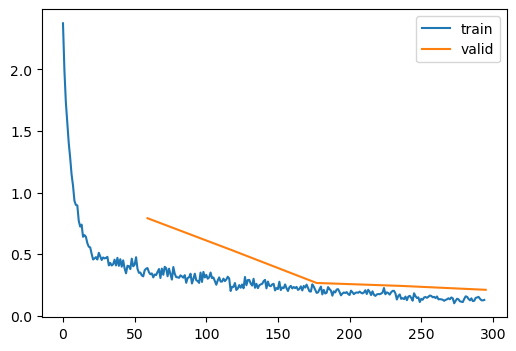

In [31]:
learn.fit(epochs)

That gives us an accuracy of **`92.4%`**. What this proves is that our custom framework driven approach, which allows us to build simple, yet well thought out, networks can perform as well as or better than alot of predesigned PyTorch models.

Common sense goes a long way!